# CS4487 Project: Image classification

## Regarding course project
* External training data is not allowed. Learning can only be performed on the 50,000 training images in **CIFAR10**
* The [**CIFAR10** dataset](https://www.cs.toronto.edu/~kriz/cifar.html) was comprised of 60,000 32 × 32 color photographs of objects from 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
* Submit the results at [Kaggle CS4487 Course Project](https://www.kaggle.com/c/cs4487cp/)
* The second test set containing roughly 2,000 images (refer to test_data/y_test.npy)

## Evaluation Criteria 

* ### Classification Accuaracy:
  ### $$ Acc(f, D) = \frac{1}{m}\sum_{i=1}^{m}\mathbb{I}[y^i = f(x^i)]$$

* ### File Format:
Upload a file in CSV format, such as:

|         **Index**         |         **Category**        |
|---------------------------|-----------------------------|
| 0                         | 8                           |
| 1                         | 4                           |
| 2                         | 6                           |
| 3                         | 1                           |
| ......                    | ......                      |
| 11999                     | 2                           |

PyTorch Tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

---
## Table of content (for quick jump)
* ### [Import Library](#Import-Library)
* ### [Data Preparation](#Data-Preparation)
* ### [Common Functions](#Common-Functions)
  * #### [Training function](#Training-function)
  * #### [Testing function](#Testing-function)
  * #### [Test for each category](#Test-for-each-category)
  * #### [Save Model](#Save-Model)
  * #### [Print Time](#Print-Time)
  * #### [Progress Bar](#Progress-Bar)
* ### [Convolutional Neural Network](#A-Basic-Image-Classifier)
  * #### [Training](#Train-the-network)
  * #### [Testing](#Test-the-network)
* ### [Dual Path Networks](#Dual-Path-Networks)
  * #### [Training](#Train-DPN)
  * #### [Testing](#Test-DPN)
* ### [Run the model in project test data](#Run-the-model-in-project-test-data)
---
---

## Import Library

In [1]:
import numpy as np
from numpy import *
import cv2
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import time
from _datetime import datetime

import torch
import torchvision
from torch.utils import data
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torch.optim as optim

from progressbar import *

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

---
---
## Data Preparation

### Read CIFAR10 data
* The archive contains the files data_batch_1, data_batch_2, ..., data_batch_5, as well as test_batch. Each of these files is a Python "pickled" object produced with cPickle.
* Loaded in this way, each of the batch files contains a dictionary with the following elements:
  * **data**: 
    * a 10,000 x 3,072 numpy array of uint8s. Each row of the array stores a 32 x 32 colour image. 
    * The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. 
    * The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
  * **labels**: 
    * a list of 10,000 numbers in the range 0 - 9. 
    * The number at index i indicates the label of the ith image in the array data.
* The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
  * **label_names** -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. 
  * For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Loading and normalizing CIFAR10 to dataloader

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
trainset = torchvision.datasets.CIFAR10(root='/data/', train=True, download=False, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=16, 
                                           shuffle=True, 
                                           num_workers=8, 
                                           pin_memory=True
                                          )

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=8,
                                          shuffle=False, 
                                          num_workers=8,
                                          pin_memory=True
                                         )

In [5]:
train_len = len(trainset)
train_len
test_len = len(testset)
test_len

50000

10000

In [6]:
category_dict = {
    'airplane': 1, 
    'automobile': 2, 
    'bird': 3, 
    'cat': 4, 
    'deer': 5, 
    'dog': 6, 
    'frog': 7, 
    'horse': 8, 
    'ship': 9, 
    'truck': 10
}

---
---
## Common Functions

### Training function

In [7]:
def training(epoch_num: int, net):

    print_time_and_msg(f"Preparing data for {epoch_num} epoches\n")
    
    final_loss = 0.0
    
    for epoch in range(epoch_num):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        print_time_and_msg(f"Start training for the {epoch + 1} epoch...")
        train_bar = progress_bar(train_len)
        
        for batch_idx, data in enumerate(train_loader, 0):
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()
            
            outputs = net(inputs)
            
            # forward + backward + optimize
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            # print statistics
            running_loss += loss.item()
            final_loss = round(running_loss / train_len, 3)
            
            train_bar.update(batch_idx)
        
        print_time_and_msg(f"Trained {epoch + 1} epoch, the loss is {final_loss}\n")
        save_model("DPN_cifar.pth", net)
    
    print_time_and_msg(f'\nFinished training total {train_len} data for {epoch_num} epoches,\nthe final loss is {final_loss}')


### Testing function

In [8]:
def testing(net):
    test_bar = progress_bar(test_len)
    correct = 0
    total = 0
    
    with torch.no_grad():
        for ti, data in enumerate(test_loader):
        
            images, labels = data#[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            test_bar.update(ti)
    
    print(f'Accuracy of the network on the {len(test_loader)} test images: {100 * correct / total}%')



### Test for each category

In [9]:
def test_for_each(net):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in test_loader:
            images, labels = data#[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    for i in range(10):
        print(f'Accuracy of {list(category_dict)[i]} : {round(100 * class_correct[i] / class_total[i], 2)}%')

### Save Model

In [10]:
def save_model(model_name: str, net):
    PATH_basic = f'./models/{model_name}'
    torch.save(net.state_dict(), PATH_basic)

### Print Time

In [11]:
def print_time_and_msg(msg: str) -> str:
    now_time = time.time()
    readable_time = datetime.fromtimestamp(now_time).strftime(f'[%H:%M:%S:%m] - {msg}')
    print(readable_time)

### Progress Bar

In [12]:
def progress_bar(max_val: int):
    bar = ProgressBar(
        widgets=[
            'Progress: ',
            Percentage(), ' ', 
            Bar('#'), ' ', 
            Timer(), ' ', 
            ETA(), ' '
        ], 
        max_value=max_val
    )
    return bar


### Unpickle CIFAR data

In [13]:
def unpickle_cifar10(file: str) -> dict:
    full_name = f"./data/cifar-10-batches-py/{file}"
    
    with open(full_name, 'rb') as fi:
        cifar10_dict = pickle.load(fi, encoding='bytes')
    return cifar10_dict

cifar_meta = unpickle_cifar10("batches.meta")
cifar_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

---
---
## A Basic Image Classifier

### Show some of the training images, for fun

In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

torch.Size([64, 3, 32, 32])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


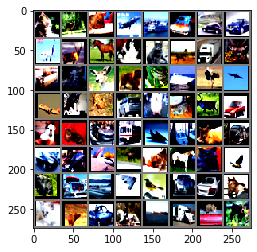

  cat  deer   dog airplane  ship automobile automobile automobile airplane  deer horse   dog   cat horse truck  deer  ship   cat  deer   dog  frog  ship  bird  bird airplane   cat  frog automobile   dog   cat  deer automobile   dog   cat automobile truck airplane  ship   dog automobile automobile automobile  bird  deer   dog horse   cat  bird  frog truck  ship airplane  bird automobile automobile horse   cat  deer automobile horse  ship truck   cat  deer


In [17]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images.shape

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % list(category_dict)[labels[j]] for j in range(len(images))))

### Define a Convolutional Neural Network

In [18]:
# argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
#         print(f"In Model: input size, {x.size()} - output size - {x.size()}")
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Define a Loss function and optimizer

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

### Jump to [project test data](#Run-the-model-in-test-data)
---

### Test the network

#### Load the saved model

In [26]:
PATH_basic = "./models/basic_cifar_net.pth"
test_net = Net()
# net.to(device)
test_net.load_state_dict(torch.load(PATH_basic))

<All keys matched successfully>

#### Display some images of test data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


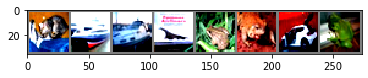

GroundTruth:    cat  ship  ship airplane  frog  frog automobile  frog

Predicted:    cat automobile automobile  ship  frog automobile automobile  frog


In [27]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % list(category_dict)[labels[j]] for j in range(len(images))))
print()

outputs = test_net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % list(category_dict)[predicted[j]]
                              for j in range(len(images))))

#### Test the network using the model

#### Show the accuracy of each category

## Dual Path Networks

### Define DPN

In [14]:
class Bottleneck(nn.Module):
    def __init__(self, last_planes, in_planes, out_planes, dense_depth, stride, first_layer):
        super(Bottleneck, self).__init__()
        self.out_planes = out_planes
        self.dense_depth = dense_depth

        self.conv1 = nn.Conv2d(last_planes, in_planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv2 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=32, bias=False)
        self.bn2 = nn.BatchNorm2d(in_planes)
        self.conv3 = nn.Conv2d(in_planes, out_planes + dense_depth, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes+dense_depth)

        self.shortcut = nn.Sequential()
        if first_layer:
            self.shortcut = nn.Sequential(
                nn.Conv2d(last_planes, out_planes + dense_depth, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes + dense_depth)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        x = self.shortcut(x)
        d = self.out_planes
        out = torch.cat([x[:,:d,:,:] + out[:,:d,:,:], x[:,d:,:,:], out[:,d:,:,:]], 1)
        out = F.relu(out)
        return out


In [15]:
class DPN(nn.Module):
    def __init__(self, cfg):
        super(DPN, self).__init__()
        in_planes, out_planes = cfg['in_planes'], cfg['out_planes']
        num_blocks, dense_depth = cfg['num_blocks'], cfg['dense_depth']

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.last_planes = 64
        self.layer1 = self._make_layer(in_planes[0], out_planes[0], num_blocks[0], dense_depth[0], stride=1)
        self.layer2 = self._make_layer(in_planes[1], out_planes[1], num_blocks[1], dense_depth[1], stride=2)
        self.layer3 = self._make_layer(in_planes[2], out_planes[2], num_blocks[2], dense_depth[2], stride=2)
        self.layer4 = self._make_layer(in_planes[3], out_planes[3], num_blocks[3], dense_depth[3], stride=2)
        self.linear = nn.Linear(out_planes[3] + (num_blocks[3] + 1) * dense_depth[3], 10)

    def _make_layer(self, in_planes, out_planes, num_blocks, dense_depth, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for i,stride in enumerate(strides):
            layers.append(Bottleneck(self.last_planes, in_planes, out_planes, dense_depth, stride, i==0))
            self.last_planes = out_planes + (i + 2) * dense_depth
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [16]:
def DPN26():
    cfg = {
        'in_planes': (96,192,384,768),
        'out_planes': (256,512,1024,2048),
        'num_blocks': (2,2,2,2),
        'dense_depth': (16,32,24,128)
    }
    return DPN(cfg)

def DPN92():
    cfg = {
        'in_planes': (96,192,384,768),
        'out_planes': (256,512,1024,2048),
        'num_blocks': (3,4,20,3),
        'dense_depth': (16,32,24,128)
    }
    return DPN(cfg)

### Train DPN

In [17]:
DPN_net = DPN26()
DPN_net.to(device)
if device == 'cuda':
    DPN_net = torch.nn.DataParallel(DPN_net)
    cudnn.benchmark = True

DPN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(96, 272, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 272, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(DPN_net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

#### Go to [training function](#Training-function)

In [ ]:
training(1, DPN_net)

[18:14:02:12] - Preparing data for 1 epoches

[18:14:02:12] - Start training for the 1 epoch...


Progress:   4% |#                       | Elapsed Time: 0:09:46 ETA:   3:10:39 

### Test DPN

In [ ]:
PATH_DPN = "./models/DPN_cifar.pth"
test_net = DPN92()
test_net.load_state_dict(torch.load(PATH_DPN))

In [ ]:
testing(test_net)

In [ ]:
test_for_each(test_net)

---
---
## Run the model in project test data 

### Load test data

In [ ]:
project_testset = np.load("./data/test_data/y_test.npy").astype(np.uint8)
project_testset = np.moveaxis(project_testset, -1, 1)
project_testset.shape
type(project_testset)
p_testset_size = len(project_testset)

### Convert to DataLoader ([Convertion Reference](https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader))

In [ ]:
from torch.utils import data
tensor_testset = torch.Tensor(project_testset)
the_dataset = data.TensorDataset(tensor_testset)
project_test_loader = data.DataLoader(the_dataset, 
                                      batch_size=p_testset_size,
                                      num_workers=8,
                                      pin_memory=True
                                     )

### Run the test

In [ ]:
predict_result = []

def run_project_test(net, model_path):
    net.load_state_dict(torch.load(model_path))
    
    test_pbar = progress_bar(p_testset_size)
    
    with torch.no_grad():
        for index, imgs in enumerate(project_test_loader):
            imgs = torch.stack([torch.Tensor(i) for i in imgs]).squeeze()
            outputs = test_net(imgs)
            _, predicted = torch.max(outputs.data, 1)
            
            predict_result = predicted
            
            test_pbar.update(index)
        
    len(predict_result)

In [ ]:
p_test_net = DPN92()
run_project_test(p_test_net, PATH_DPN)

### Save to csv file

In [ ]:
result_df = pd.DataFrame(
    list(predict_result),
    columns=["Category"]
)
result_df.index.name = "Index"
# result_df

In [ ]:
result_df.to_csv("predict_result.csv")